In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
%matplotlib inline
from sklearn import model_selection

## RBM

In [2]:
from __future__ import print_function
import numpy as np

class RBM:
  
  def __init__(self, num_visible, num_hidden, weights):
    self.num_hidden = num_hidden
    self.num_visible = num_visible
    self.debug_print = True

    # Initialize a weight matrix, of dimensions (num_visible x num_hidden), using
    # a uniform distribution between -sqrt(6. / (num_hidden + num_visible))
    # and sqrt(6. / (num_hidden + num_visible)). One could vary the 
    # standard deviation by multiplying the interval with appropriate value.
    # Here we initialize the weights with mean 0 and standard deviation 0.1. 
    # Reference: Understanding the difficulty of training deep feedforward 
    # neural networks by Xavier Glorot and Yoshua Bengio
    np_rng = np.random.RandomState(1234)
    
    if weights is None:
        self.weights = np.asarray(np_rng.uniform(
                low=-0.1 * np.sqrt(6. / (num_hidden + num_visible)),
                            high=0.1 * np.sqrt(6. / (num_hidden + num_visible)),
                            size=(num_visible, num_hidden)))


        # Insert weights for the bias units into the first row and first column.
        self.weights = np.insert(self.weights, 0, 0, axis = 0)
        self.weights = np.insert(self.weights, 0, 0, axis = 1)
    else:
        self.weights = weights

  def train(self, data, max_epochs = 1000, learning_rate = 0.1):
    """
    Train the machine.

    Parameters
    ----------
    data: A matrix where each row is a training example consisting of the states of visible units.    
    """

    num_examples = data.shape[0]

    # Insert bias units of 1 into the first column.
    data = np.insert(data, 0, 1, axis = 1)

    for epoch in range(max_epochs):      
      # Clamp to the data and sample from the hidden units. 
      # (This is the "positive CD phase", aka the reality phase.)
      pos_hidden_activations = np.dot(data, self.weights)      
      pos_hidden_probs = self._logistic(pos_hidden_activations)
      pos_hidden_probs[:,0] = 1 # Fix the bias unit.
      pos_hidden_states = pos_hidden_probs > np.random.rand(num_examples, self.num_hidden + 1)
      # Note that we're using the activation *probabilities* of the hidden states, not the hidden states       
      # themselves, when computing associations. We could also use the states; see section 3 of Hinton's 
      # "A Practical Guide to Training Restricted Boltzmann Machines" for more.
      pos_associations = np.dot(data.T, pos_hidden_probs)

      # Reconstruct the visible units and sample again from the hidden units.
      # (This is the "negative CD phase", aka the daydreaming phase.)
      neg_visible_activations = np.dot(pos_hidden_states, self.weights.T)
      neg_visible_probs = self._logistic(neg_visible_activations)
      neg_visible_probs[:,0] = 1 # Fix the bias unit.
      neg_hidden_activations = np.dot(neg_visible_probs, self.weights)
      neg_hidden_probs = self._logistic(neg_hidden_activations)
      # Note, again, that we're using the activation *probabilities* when computing associations, not the states 
      # themselves.
      neg_associations = np.dot(neg_visible_probs.T, neg_hidden_probs)

      # Update weights.
      self.weights += learning_rate * ((pos_associations - neg_associations) / num_examples)

      error = np.sum((data - neg_visible_probs) ** 2)
      if self.debug_print and epoch % 100 == 0:
        print("Epoch %s: error is %s" % (epoch, error))

  def run_visible(self, data, keep_prob = False):
    """
    Assuming the RBM has been trained (so that weights for the network have been learned),
    run the network on a set of visible units, to get a sample of the hidden units.
    
    Parameters
    ----------
    data: A matrix where each row consists of the states of the visible units.
    
    Returns
    -------
    hidden_states: A matrix where each row consists of the hidden units activated from the visible
    units in the data matrix passed in.
    """
    
    num_examples = data.shape[0]
    
    # Create a matrix, where each row is to be the hidden units (plus a bias unit)
    # sampled from a training example.
    hidden_states = np.ones((num_examples, self.num_hidden + 1))
    
    # Insert bias units of 1 into the first column of data.
    data = np.insert(data, 0, 1, axis = 1)

    # Calculate the activations of the hidden units.
    hidden_activations = np.dot(data, self.weights)
    # Calculate the probabilities of turning the hidden units on.
    hidden_probs = self._logistic(hidden_activations)
    if keep_prob:
        hidden_states[:,:] = hidden_probs
    else:
        # Turn the hidden units on with their specified probabilities.
        hidden_states[:,:] = hidden_probs > np.random.rand(num_examples, self.num_hidden + 1)
        # Always fix the bias unit to 1.
        # hidden_states[:,0] = 1
  
    # Ignore the bias units.
    hidden_states = hidden_states[:,1:]
    return hidden_states
    
  # TODO: Remove the code duplication between this method and `run_visible`?
  def run_hidden(self, data, keep_prob = False):
    """
    Assuming the RBM has been trained (so that weights for the network have been learned),
    run the network on a set of hidden units, to get a sample of the visible units.

    Parameters
    ----------
    data: A matrix where each row consists of the states of the hidden units.

    Returns
    -------
    visible_states: A matrix where each row consists of the visible units activated from the hidden
    units in the data matrix passed in.
    """

    num_examples = data.shape[0]

    # Create a matrix, where each row is to be the visible units (plus a bias unit)
    # sampled from a training example.
    visible_states = np.ones((num_examples, self.num_visible + 1))

    # Insert bias units of 1 into the first column of data.
    data = np.insert(data, 0, 1, axis = 1)

    # Calculate the activations of the visible units.
    visible_activations = np.dot(data, self.weights.T)
    # Calculate the probabilities of turning the visible units on.
    visible_probs = self._logistic(visible_activations)
    if keep_prob:
        visible_states[:,:] = visible_probs
    else:
        # Turn the visible units on with their specified probabilities.
        visible_states[:,:] = visible_probs > np.random.rand(num_examples, self.num_visible + 1)
        # Always fix the bias unit to 1.
        # visible_states[:,0] = 1

    # Ignore the bias units.
    visible_states = visible_states[:,1:]
    return visible_states
    
  def daydream(self, num_samples):
    """
    Randomly initialize the visible units once, and start running alternating Gibbs sampling steps
    (where each step consists of updating all the hidden units, and then updating all of the visible units),
    taking a sample of the visible units at each step.
    Note that we only initialize the network *once*, so these samples are correlated.

    Returns
    -------
    samples: A matrix, where each row is a sample of the visible units produced while the network was
    daydreaming.
    """

    # Create a matrix, where each row is to be a sample of of the visible units 
    # (with an extra bias unit), initialized to all ones.
    samples = np.ones((num_samples, self.num_visible + 1))

    # Take the first sample from a uniform distribution.
    samples[0,1:] = np.random.rand(self.num_visible)

    # Start the alternating Gibbs sampling.
    # Note that we keep the hidden units binary states, but leave the
    # visible units as real probabilities. See section 3 of Hinton's
    # "A Practical Guide to Training Restricted Boltzmann Machines"
    # for more on why.
    for i in range(1, num_samples):
      visible = samples[i-1,:]

      # Calculate the activations of the hidden units.
      hidden_activations = np.dot(visible, self.weights)      
      # Calculate the probabilities of turning the hidden units on.
      hidden_probs = self._logistic(hidden_activations)
      # Turn the hidden units on with their specified probabilities.
      hidden_states = hidden_probs > np.random.rand(self.num_hidden + 1)
      # Always fix the bias unit to 1.
      hidden_states[0] = 1

      # Recalculate the probabilities that the visible units are on.
      visible_activations = np.dot(hidden_states, self.weights.T)
      visible_probs = self._logistic(visible_activations)
      visible_states = visible_probs > np.random.rand(self.num_visible + 1)
      samples[i,:] = visible_states

    # Ignore the bias units (the first column), since they're always set to 1.
    return samples[:,1:]        
      
  def _logistic(self, x):
    return 1.0 / (1 + np.exp(-x))

## 载入数据集

In [3]:
# MovieLens数据集
ratings = pd.read_csv('ratings.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [4]:
ratings.count()

userId       100004
movieId      100004
rating       100004
timestamp    100004
dtype: int64

In [5]:
data = ratings[['userId', 'movieId']].values
data

array([[   1,   31],
       [   1, 1029],
       [   1, 1061],
       ...,
       [ 671, 6365],
       [ 671, 6385],
       [ 671, 6565]], dtype=int64)

In [6]:
data.shape

(100004, 2)

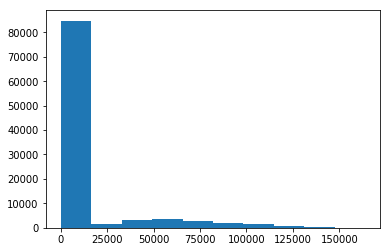

In [7]:
plt.hist(data[:,1]);

## 重新编排ID

In [8]:
def unique_data(data):
    index = 0
    table = {}
    reverse = {}
    unique = []
    for x in data:
        if x not in table:
            index += 1
            table[x] = index
            reverse[index] = x
        unique.append(table[x])
    return np.array(unique), table, reverse

In [9]:
user_unique, user_table, user_reverse = unique_data(data[:,0])
movie_unique, movie_table, movie_reverse = unique_data(data[:,1])
data_unique = np.array([user_unique, movie_unique]).T

In [10]:
data_unique

array([[   1,    1],
       [   1,    2],
       [   1,    3],
       ...,
       [ 671, 1330],
       [ 671, 1332],
       [ 671, 2947]])

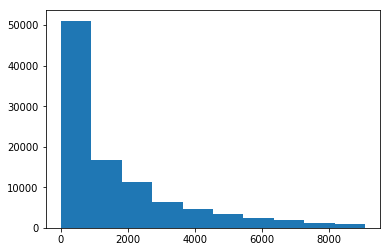

In [11]:
plt.hist(data_unique[:,1]);

## 分割数据集

In [12]:
user_num = user_unique.max()
user_num

671

In [13]:
movie_num = movie_unique.max()
movie_num

9066

In [14]:
# 完整数据集矩阵
full_matrix = np.zeros((user_num, movie_num))
for user, movie in data_unique:
    full_matrix[user - 1, movie - 1] = 1
full_matrix

array([[1., 1., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [15]:
full_matrix.shape

(671, 9066)

In [16]:
# 随机从观影数量至少40部的用户中抽取5部影片作为测试集，选择25%的用户作为测试
least_item = 40
test_sample_num = 5
indexes = pd.Series(np.where(full_matrix.sum(axis=1) >= least_item)[0])
choosed_indexes = indexes.sample(user_num // 4, random_state=47)

# 生成测试集
test_matrix = np.zeros((user_num, movie_num))
for index in choosed_indexes:
    item_indexes = pd.Series(np.where(full_matrix[index] == 1)[0])
    choosed_item_indexes = item_indexes.sample(test_sample_num, random_state=47)
    test_matrix[index, choosed_item_indexes] = 1
    
# 生成训练集
train_matrix = full_matrix - test_matrix

In [17]:
train_matrix.sum()

99169.0

In [18]:
test_matrix.sum()

835.0

In [19]:
full_matrix.sum()

100004.0

## 训练RBM模型

In [20]:
# 从文件中读取上次训练完毕的模型
weights = None

try:
    fr = open('rbm_weights','rb')
    weights = pickle.load(fr)
    fr.close()
except IOError:
    print("File is not accessible.")

In [21]:
r = RBM(num_visible = movie_num, num_hidden = 300, weights = weights)

In [22]:
r.train(train_matrix, max_epochs = 500, learning_rate = 1)

D:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:205: RuntimeWarning: overflow encountered in exp


Epoch 0: error is 15420.140518350538
Epoch 100: error is 15357.715290381298
Epoch 200: error is 15258.16906057091
Epoch 300: error is 15254.256368927656
Epoch 400: error is 15201.473567412238


In [23]:
# 将此次训练完毕的模型存入文件
try:
    fw = open('rbm_weights','wb')
    pickle.dump(r.weights, fw)
    fw.close()
except IOError:
    print("File is not accessible.")

In [24]:
r.weights.shape

(9067, 301)

## 测试集效果验证准备

In [25]:
# 计算准确率和召回率
def compute_score(test, pred):
    Y = test.flatten()
    P = pred.flatten()
    hit = sum(Y * P)
    precision = hit / sum(P)
    recall = hit / sum(Y)
    return precision, recall

In [26]:
mini_train_matrix = train_matrix[choosed_indexes]
mini_train_matrix.shape

(167, 9066)

In [27]:
mini_test_matrix = test_matrix[choosed_indexes]
mini_test_matrix.shape

(167, 9066)

In [28]:
# topN推荐，取5部电影
topN = 5

## 计算RBM的准确率和召回率

In [29]:
# hidden = r.run_visible(mini_train_matrix)
hidden = r.run_visible(mini_train_matrix, keep_prob=True) >= 0.5
pred_prob_matrix = r.run_hidden(hidden, keep_prob=True)
pred_prob_matrix[mini_train_matrix == 1] = 0
top_indexes = pred_prob_matrix.argpartition(-topN)[:, -topN:]
pred_matrix = np.zeros_like(mini_train_matrix)
for i in range(pred_matrix.shape[0]):
    pred_matrix[i, top_indexes[i]] = 1

D:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:205: RuntimeWarning: overflow encountered in exp


In [30]:
compute_score(mini_test_matrix, pred_matrix)

(0.0658682634730539, 0.0658682634730539)

## 计算热门推荐的准确率和召回率

In [31]:
# 提前计算好各影片的热度，即被观看的次数
popularity = train_matrix.sum(axis=0)
popularity

array([40., 40., 33., ...,  1.,  1.,  1.])

In [32]:
# 构建热度矩阵
popularity_matrix = np.zeros_like(mini_train_matrix)
popularity_matrix[:,] = popularity
# 去除该用户已经观看过的影片
popularity_matrix[mini_train_matrix == 1] = 0
# 热度矩阵的topN排序，按行分别排序，取前topN个
top_indexes = popularity_matrix.argpartition(-topN)[:, -topN:]

# 构建预测矩阵
pred_matrix = np.zeros_like(mini_train_matrix)
# 生成预测矩阵
for i in range(pred_matrix.shape[0]):
    pred_matrix[i, top_indexes[i]] = 1

In [33]:
compute_score(mini_test_matrix, pred_matrix)

(0.05748502994011976, 0.05748502994011976)

## 计算ItemCF的准确率的召回率

In [34]:
# 提前计算好各影片被观看的次数，用于计算余弦相似性
models = np.sqrt(train_matrix.sum(axis=0))
models

array([6.32455532, 6.32455532, 5.74456265, ..., 1.        , 1.        ,
       1.        ])

In [35]:
# 计算用户活跃度
user_activity = np.log(1 + train_matrix.sum(axis=1))
# 计算带有活跃度惩罚的训练矩阵
uif_train_matrix = train_matrix / user_activity.reshape(train_matrix.shape[0], 1)

In [36]:
# 计算影片之间的余弦相似性矩阵
similarity_matrix = np.zeros((movie_num, movie_num))
for i in range(movie_num):
    if i % 1000 == 0:
        print('movie',i)
    if models[i] > 0:
        for j in range(i + 1, movie_num):
            deno = models[i] * models[j]
            if deno > 0:
                item1 = uif_train_matrix[:,i]
                item2 = uif_train_matrix[:,j]
                similarity = item1 @ item2 / deno # 计算余弦相似性
                similarity_matrix[i, j] = similarity
                similarity_matrix[j, i] = similarity

movie 0
movie 1000
movie 2000
movie 3000
movie 4000
movie 5000
movie 6000
movie 7000
movie 8000
movie 9000


In [37]:
# 影片之间的余弦相似性矩阵
similarity_matrix

array([[0.        , 0.00532932, 0.00909425, ..., 0.        , 0.        ,
        0.        ],
       [0.00532932, 0.        , 0.00679634, ..., 0.00430014, 0.00430014,
        0.        ],
       [0.00909425, 0.00679634, 0.        , ..., 0.0047343 , 0.0047343 ,
        0.        ],
       ...,
       [0.        , 0.00430014, 0.0047343 , ..., 0.        , 0.02719646,
        0.        ],
       [0.        , 0.00430014, 0.0047343 , ..., 0.02719646, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [38]:
# 对余弦相似性矩阵进行归一化（归一化实际效果并不好，未采用）
max_similarity = similarity_matrix.max(axis=1).reshape(similarity_matrix.shape[0], 1)
normalized_similarity_matrix = similarity_matrix / (max_similarity + 1e-7)
normalized_similarity_matrix

array([[0.        , 0.31241936, 0.53312969, ..., 0.        , 0.        ,
        0.        ],
       [0.2986048 , 0.        , 0.38080251, ..., 0.24093896, 0.24093896,
        0.        ],
       [0.59732885, 0.44639732, 0.        , ..., 0.31095807, 0.31095807,
        0.        ],
       ...,
       [0.        , 0.1581133 , 0.17407702, ..., 0.        , 0.99999632,
        0.        ],
       [0.        , 0.1581133 , 0.17407702, ..., 0.99999632, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [39]:
# 构建预测矩阵
pred_matrix = np.zeros_like(mini_train_matrix)

# 生成预测矩阵
for i in range(mini_train_matrix.shape[0]):
    item_slice = mini_train_matrix[i] == 1
    # 第i个用户观看过的所有影片组成的影片相似性子表
    sub_similarity_matrix = similarity_matrix[item_slice]
    # 从影片相似性子表中去除该用户已经观看过的影片
    sub_similarity_matrix[:, item_slice] = 0
    # 影片相似性子表的topN排序，按行分别排序，取前topN个
    selected_indexes = sub_similarity_matrix.argpartition(-topN)[:, -topN:]
    # 获取所有入选影片的index列表
    selected_index_list = np.array(list(set(selected_indexes.flatten())))
    # 入选影片相似性子表
    selected_sub_matrix = similarity_matrix[selected_index_list]
    selected_sub_matrix = selected_sub_matrix[:, item_slice]
    # 入选影片与该用户观看过的影片相似性求和，作为分数
    score_sum = selected_sub_matrix.sum(axis=1)
    # 获取分数最高的前topN影片index
    top_sum_indexes = selected_index_list[score_sum.argpartition(-topN)[-topN:]]
    # 预测该用户的topN影片
    pred_matrix[i, top_sum_indexes] = 1

In [40]:
compute_score(mini_test_matrix, pred_matrix)

(0.10538922155688622, 0.10538922155688622)